# Modeling Text From Trained Word Embeddings (TFIDF)

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, average_precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import eli5
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from gensim.models.word2vec import Word2Vec
from sklearn.neural_network import MLPClassifier
%matplotlib inline

In [3]:
#raw = pd.read_csv('train_preprocessed.csv')
#raw.dropna(inplace=True)

In [4]:
subset_amount = .1
raw = pd.read_csv(r'train_preprocessed.csv', skiprows=lambda i: i>0 and random.random() > subset_amount, 
                  usecols=['clean_question_text','target','qid'])
raw.dropna(inplace=True)

In [5]:
%time
X, y = raw.clean_question_text, raw.target

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


Vectorizer object code from: http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In addition to Count Vectorizer and TFIDF, classification models can model on represented by Word Embeddings, defined by Wikipedia as:

> The collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers.

While the tradition bag of words approaches can be useful in some contexts, Word Embeddings are a more complex option, as they also encode specific contextual information about certain words relate to others.

In addition to training Word Embeddings on your specific corpus, you can also use pre-trained embeddings from across the internet. There are many different types of embeddings, trained on huuuuge corpuses, such as the entireity of the aforementioned wikipedia, for example! And the embeddings come in all sizes, which may or may not be appropriate for the data you have (or the classifier we're using). Word embeddings are a form of transfer learning, and transfer learning has become an emerging best practice in NLP in recent times: http://jalammar.github.io/illustrated-bert/

For this notebook, we will be using the Stanford Glove pre-trained word embedding, but in the future I intend to test additional word embeddings of all shapes and sizes.

To acquire Glove, use the following code (and uncomment if needed)

```

import zipfile
#this is the small version - trained on 6B tokens - 822 MB download, 2GB unzipped
wget http://nlp.stanford.edu/data/glove.6B.zip 
zip = zipfile.ZipFile('glove.6B.zip')
zip.extractall() 


#this is the huge version, trained on 840B tokens - 2GB compressed, 5GB unzipped
#wget http://nlp.stanford.edu/data/glove.840B.300d.zip
#zip = zipfile.ZipFile('glove.840B.300d.zip')
#zip.extractall()
```

Create the dictionary of words and weights

In [6]:
import numpy as np
encoding="utf-8"
with open('glove.6B.50d.txt', "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

Create the model, based on the Glove Embedding

In [7]:
import struct 

glove_small = {}
all_words = set(w for words in X for w in words)
with open('glove.6B.50d.txt', "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

Instantiate the MeanEmbeddingVector Object (same one used when we trained our corpus).

In [8]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Instantiate the vector by using the class object above on the created dictionary

In [10]:
mean_vect = TfidfEmbeddingVectorizer(wvec)

Now this instantiated object works just like Countvectorizer or TFIDF

In [11]:
%time
mean_vect.fit(X,y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


In [12]:
%time
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0) 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [13]:
%time
X_train = mean_vect.transform(X_train)
X_test = mean_vect.transform(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


In [14]:
%time
LR_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=42,max_iter=4000,verbose=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


In [15]:
%time
LR_classifier.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)

In [16]:
%time

y_preds_test=LR_classifier.predict(X_test)
y_probas_test=LR_classifier.predict_proba(X_test)

y_preds_train=LR_classifier.predict(X_train)
y_probas_train=LR_classifier.predict_proba(X_train)

y_true_train = y_train.values
y_true_test = y_test.values

print("Train Accuracy Score: ", accuracy_score(y_true_train, y_preds_train))
print("Test Accuracy Score: ", accuracy_score(y_true_test, y_preds_test))
print("Train F1 Score: ", f1_score(y_true_train, y_preds_train))
print("Test F1 Score: ", f1_score(y_true_test, y_preds_test))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs
Train Accuracy Score:  0.9379818845113534
Test Accuracy Score:  0.9389365879952258
Train F1 Score:  0.00031031807602792866
Test F1 Score:  0.0


Interesting note about F-score being "ill-defined and being set to 0.0." That happens when the positive class is never predicted.

## Naive Bayes (Multinomial)

In [17]:
%time

MNB_classifier = MultinomialNB()
MNB_classifier.fit(X_train, y_train)

y_preds_test=MNB_classifier.predict(X_test)
y_probas_test=MNB_classifier.predict_proba(X_test)

y_preds_train=MNB_classifier.predict(X_train)
y_probas_train=MNB_classifier.predict_proba(X_train)

y_true_train = y_train.values
y_true_test = y_test.values

print("Train Accuracy Score: ", accuracy_score(y_true_train, y_preds_train))
print("Test Accuracy Score: ", accuracy_score(y_true_test, y_preds_test))
print("Train F1 Score: ", f1_score(y_true_train, y_preds_train))
print("Test F1 Score: ", f1_score(y_true_test, y_preds_test))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


ValueError: Input X must be non-negative

Looks like Multinomial Naive Bayes cannot work with this, since it gives negative values.

In [19]:
%time

BNB_classifier = BernoulliNB()
BNB_classifier.fit(X_train, y_train)

y_preds_test=BNB_classifier.predict(X_test)
y_probas_test=BNB_classifier.predict_proba(X_test)

y_preds_train=BNB_classifier.predict(X_train)
y_probas_train=BNB_classifier.predict_proba(X_train)

y_true_train = y_train.values
y_true_test = y_test.values

print("Train Accuracy Score: ", accuracy_score(y_true_train, y_preds_train))
print("Test Accuracy Score: ", accuracy_score(y_true_test, y_preds_test))
print("Train F1 Score: ", f1_score(y_true_train, y_preds_train))
print("Test F1 Score: ", f1_score(y_true_test, y_preds_test))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
Train Accuracy Score:  0.9381840233325953
Test Accuracy Score:  0.9392060986408963
Train F1 Score:  0.0
Test F1 Score:  0.0


/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Extra Trees

In [20]:
%time
ET_classifier = ExtraTreesClassifier(n_estimators=200,random_state=420,verbose=2,max_features=.05)
ET_classifier.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.8s finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.05, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=420, verbose=2, warm_start=False)

In [21]:
y_preds_test=ET_classifier.predict(X_test)
y_probas_test=ET_classifier.predict_proba(X_test)

y_preds_train=ET_classifier.predict(X_train)
y_probas_train=ET_classifier.predict_proba(X_train)

y_true_train = y_train.values
y_true_test = y_test.values

print("Train Accuracy Score: ", accuracy_score(y_true_train, y_preds_train))
print("Test Accuracy Score: ", accuracy_score(y_true_test, y_preds_test))
print("Train F1 Score: ", f1_score(y_true_train, y_preds_train))
print("Test F1 Score: ", f1_score(y_true_test, y_preds_test))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Train Accuracy Score:  0.9999422460510737
Test Accuracy Score:  0.9392446001617064
Train F1 Score:  0.9995326374824739
Test F1 Score:  0.0012658227848101266


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.2s finished


In [22]:
eclf1 = VotingClassifier(estimators=[('lr', LR_classifier), ('et', ET_classifier), ('nb', BNB_classifier)], voting='soft')

In [23]:
eclf1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 20

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   17.7s finished


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=1, warm_start=False)), ('et', Extr... warm_start=False)), ('nb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [24]:
y_preds_test=eclf1.predict(X_test)
y_probas_test=eclf1.predict_proba(X_test)

y_preds_train=eclf1.predict(X_train)
y_probas_train=eclf1.predict_proba(X_train)

y_true_train = y_train.values
y_true_test = y_test.values

print("Train Accuracy Score: ", accuracy_score(y_true_train, y_preds_train))
print("Test Accuracy Score: ", accuracy_score(y_true_test, y_preds_test))
print("Train F1 Score: ", f1_score(y_true_train, y_preds_train))
print("Test F1 Score: ", f1_score(y_true_test, y_preds_test))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.2s finished
/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size

Train Accuracy Score:  0.938405413470146
Test Accuracy Score:  0.9392060986408963
Train F1 Score:  0.007137315748642358
Test F1 Score:  0.0


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.3s finished
/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
MLP_classifier = MLPClassifier(solver='lbfgs', alpha=1e-4,hidden_layer_sizes=(20,10, 2), random_state=42)
MLP_classifier.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 10, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [26]:
y_preds_test=MLP_classifier.predict(X_test)
y_probas_test=MLP_classifier.predict_proba(X_test)

y_preds_train=MLP_classifier.predict(X_train)
y_probas_train=MLP_classifier.predict_proba(X_train)

y_true_train = y_train.values
y_true_test = y_test.values

print("Train Accuracy Score: ", accuracy_score(y_true_train, y_preds_train))
print("Test Accuracy Score: ", accuracy_score(y_true_test, y_preds_test))
print("Train F1 Score: ", f1_score(y_true_train, y_preds_train))
print("Test F1 Score: ", f1_score(y_true_test, y_preds_test))

Train Accuracy Score:  0.9381840233325953
Test Accuracy Score:  0.9392060986408963
Train F1 Score:  0.0
Test F1 Score:  0.0


/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plotting

In [27]:
y_probas_test_LR=LR_classifier.predict_proba(X_test)
y_probas_test_ET=ET_classifier.predict_proba(X_test)
y_probas_test_NB=BNB_classifier.predict_proba(X_test)
y_probas_test_EC=eclf1.predict_proba(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished


In [28]:
pred_proba_df_ec = pd.DataFrame(y_probas_test_EC)
pred_proba_df_lr = pd.DataFrame(y_probas_test_LR)
pred_proba_df_nb = pd.DataFrame(y_probas_test_NB)
pred_proba_df_et = pd.DataFrame(y_probas_test_ET)

In [29]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                  0.4,0.45,0.5,0.55,0.6,0.65,
                  .7,.75,.8,.85,.9,.95,.99]

### Ensemble Frame

In [30]:
pred_proba_df_ec = pd.DataFrame(y_probas_test_EC)

In [31]:
true_poses = []
false_poses = []
accuracy_scores = []
prec_scores = []
recall_scores = []

In [32]:
for i in threshold_list:
    y_test_pred = pred_proba_df_ec.applymap(lambda x: 1 if x>i else 0)
    
    new_y_true = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    new_y_preds = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);

    true_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[1][1]
    true_poses.append(true_pos)
    
    false_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[0][1]
    false_poses.append(false_pos)
    
    acc_score = accuracy_score(new_y_true,new_y_preds)
    accuracy_scores.append(acc_score)
    
    precscore = precision_score(new_y_true,new_y_preds)
    prec_scores.append(precscore)
    
    recscore = recall_score(new_y_true,new_y_preds)
    recall_scores.append(recscore)

/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
prob_results_ec = pd.DataFrame(threshold_list)
prob_results_ec['True_Positives'] = true_poses
prob_results_ec['False_Positives'] = false_poses
prob_results_ec['Accuracy_Scores'] = accuracy_scores
prob_results_ec['Recall_Scores'] = recall_scores
prob_results_ec['Precision_Scores'] = prec_scores
prob_results_ec['F1'] =  2 * ((prob_results_ec['Precision_Scores'] * prob_results_ec['Recall_Scores'])
/   (prob_results_ec['Precision_Scores'] + prob_results_ec['Recall_Scores']))

In [34]:
prob_results_ec.columns = ['thresholds','True_Positives', 'False_Positives', 'Accuracy_Scores','Recall_Scores','Precision_Scores','F1']

### LR Frame

In [35]:
true_poses = []
false_poses = []
accuracy_scores = []
prec_scores = []
recall_scores = []

In [36]:
for i in threshold_list:
    y_test_pred = pred_proba_df_lr.applymap(lambda x: 1 if x>i else 0)
    
    new_y_true = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    new_y_preds = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);

    true_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[1][1]
    true_poses.append(true_pos)
    
    false_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[0][1]
    false_poses.append(false_pos)
    
    acc_score = accuracy_score(new_y_true,new_y_preds)
    accuracy_scores.append(acc_score)
    
    precscore = precision_score(new_y_true,new_y_preds)
    prec_scores.append(precscore)
    
    recscore = recall_score(new_y_true,new_y_preds)
    recall_scores.append(recscore)

/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
prob_results_lr = pd.DataFrame(threshold_list)

In [38]:
prob_results_lr['True_Positives'] = true_poses
prob_results_lr['False_Positives'] = false_poses
prob_results_lr['Accuracy_Scores'] = accuracy_scores
prob_results_lr['Recall_Scores'] = recall_scores
prob_results_lr['Precision_Scores'] = prec_scores
prob_results_lr['F1'] =  2 * ((prob_results_lr['Precision_Scores'] * prob_results_lr['Recall_Scores'])
/   (prob_results_lr['Precision_Scores'] + prob_results_lr['Recall_Scores']))

In [39]:
prob_results_lr.columns = ['thresholds','True_Positives', 'False_Positives', 'Accuracy_Scores','Recall_Scores','Precision_Scores','F1']

### NB Frame

In [40]:
true_poses = []
false_poses = []
accuracy_scores = []
prec_scores = []
recall_scores = []

In [41]:
for i in threshold_list:
    y_test_pred = pred_proba_df_nb.applymap(lambda x: 1 if x>i else 0)
    
    new_y_true = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    new_y_preds = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);

    true_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[1][1]
    true_poses.append(true_pos)
    
    false_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[0][1]
    false_poses.append(false_pos)
    
    acc_score = accuracy_score(new_y_true,new_y_preds)
    accuracy_scores.append(acc_score)
    
    precscore = precision_score(new_y_true,new_y_preds)
    prec_scores.append(precscore)
    
    recscore = recall_score(new_y_true,new_y_preds)
    recall_scores.append(recscore)

/home/ubuntu/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
prob_results_nb = pd.DataFrame(threshold_list)

In [43]:
prob_results_nb['True_Positives'] = true_poses
prob_results_nb['False_Positives'] = false_poses
prob_results_nb['Accuracy_Scores'] = accuracy_scores
prob_results_nb['Recall_Scores'] = recall_scores
prob_results_nb['Precision_Scores'] = prec_scores
prob_results_nb['F1'] =  2 * ((prob_results_lr['Precision_Scores'] * prob_results_nb['Recall_Scores'])
/   (prob_results_nb['Precision_Scores'] + prob_results_nb['Recall_Scores']))

In [44]:
prob_results_nb.columns = ['thresholds','True_Positives', 'False_Positives', 'Accuracy_Scores','Recall_Scores','Precision_Scores','F1']

## Extra Trees Frame

In [45]:
true_poses = []
false_poses = []
accuracy_scores = []
prec_scores = []
recall_scores = []

In [46]:
for i in threshold_list:
    y_test_pred = pred_proba_df_et.applymap(lambda x: 1 if x>i else 0)
    
    new_y_true = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    new_y_preds = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);

    true_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[1][1]
    true_poses.append(true_pos)
    
    false_pos = pd.DataFrame(confusion_matrix(new_y_true,new_y_preds))[0][1]
    false_poses.append(false_pos)
    
    acc_score = accuracy_score(new_y_true,new_y_preds)
    accuracy_scores.append(acc_score)
    
    precscore = precision_score(new_y_true,new_y_preds)
    prec_scores.append(precscore)
    
    recscore = recall_score(new_y_true,new_y_preds)
    recall_scores.append(recscore)

In [47]:
prob_results_et = pd.DataFrame(threshold_list)

In [48]:
prob_results_et['True_Positives'] = true_poses
prob_results_et['False_Positives'] = false_poses
prob_results_et['Accuracy_Scores'] = accuracy_scores
prob_results_et['Recall_Scores'] = recall_scores
prob_results_et['Precision_Scores'] = prec_scores
prob_results_et['F1'] =  2 * ((prob_results_et['Precision_Scores'] * prob_results_et['Recall_Scores'])
/   (prob_results_et['Precision_Scores'] + prob_results_et['Recall_Scores']))

In [49]:
def pos_plotter(data,title):
  plt.plot('thresholds', 'True_Positives', data=data)
  plt.plot('thresholds', 'False_Positives', data=data)
  plt.xlabel('Confidence Threshold')
  plt.title('True and False Positives ({})'.format(title))
  plt.ylabel('Totals')
  
  plt.legend()

In [50]:
prob_results_et.columns = ['thresholds','True_Positives', 'False_Positives', 'Accuracy_Scores','Recall_Scores','Precision_Scores','F1']

# Plot the model results

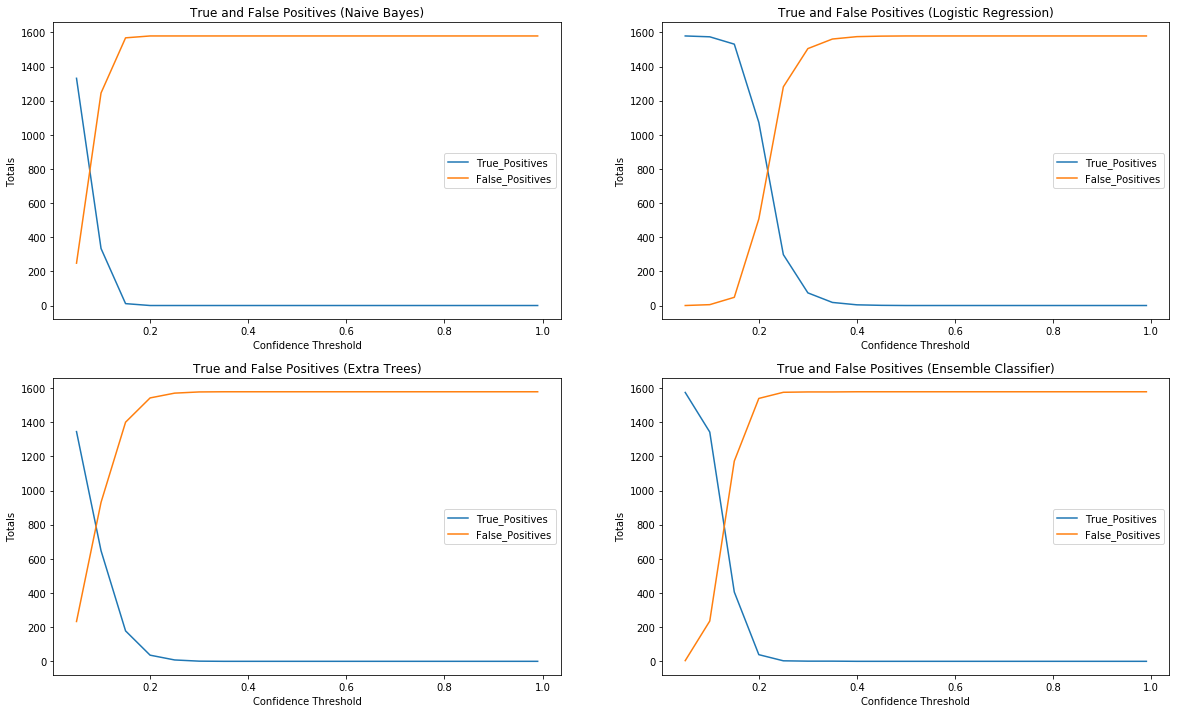

In [51]:
fig = plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
pos_plotter(prob_results_nb,'Naive Bayes')
plt.subplot(2, 2, 2)
pos_plotter(prob_results_lr,'Logistic Regression')
plt.subplot(2, 2, 3)
pos_plotter(prob_results_et,'Extra Trees')
plt.subplot(2, 2, 4)
pos_plotter(prob_results_ec,'Ensemble Classifier')
plt.show()

Weirdly every single model has a step-like shape. Not sure if this due to the embedding, the relatively small corpus size, or both.

# Plot the classification scores

In [52]:
def score_plotter(data, title):

  plt.plot('thresholds', 'Accuracy_Scores', data=data)
  plt.plot('thresholds', 'Recall_Scores', data=data)
  plt.plot('thresholds', 'Precision_Scores', data=data)
  plt.plot('thresholds', 'F1', data=data)
  plt.xlabel('Confidence Threshold')
  plt.ylabel('Score')
  plt.title('Classification Scores at Different Thresholds ({})'.format(title))
  plt.legend()

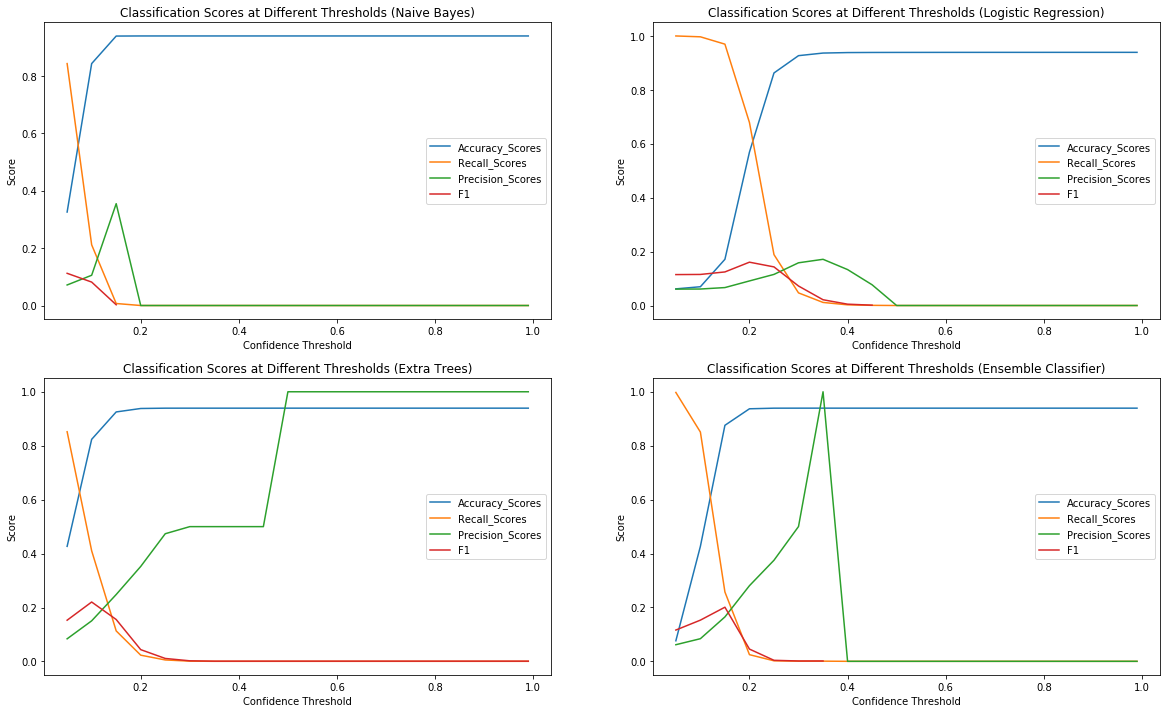

In [53]:
fig = plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
score_plotter(prob_results_nb,'Naive Bayes')
plt.subplot(2, 2, 2)
score_plotter(prob_results_lr,'Logistic Regression')
plt.subplot(2, 2, 3)
score_plotter(prob_results_et, 'Extra Trees')
plt.subplot(2, 2, 4)
score_plotter(prob_results_ec, 'Ensemble Classifier')
plt.show()

Some very bizarre shapes, but once again the ensemble classifier looks the most balanced. Obviously MAJOR caveats at this moment, since both the Word2Vec model and classification models were only trained on 10% of the data, but the code to run the notebook with all of the available data is commented at the top of the notebook, as well.

Very interesting to note that ET had such a high recall after .5, but none of the other models had a high recall at all. The ensemble classifier has a very strange peak shape and reaches a very high precision score a bit before .4, before dropping extremely sharply.